### Ny analys på uppdaterad miljö. Imputerar med regressionsanalys  för de ranker med missing. Modellen ska plocka de tre högst scorade hästarna i varje lopp. För att modellen ska anses bättre än VNUM1-3 så är det mot denna mängd vi jämför

__Ta bort VNUM, ODDS, V75procent och Grupp i analysen__

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score



In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [100]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
df0 = pd.read_excel('AllData.xlsx')

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24585 entries, 0 to 24584
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datum        24585 non-null  datetime64[ns]
 1   Arstid       24585 non-null  int64         
 2   Distans      24585 non-null  int64         
 3   Startsatt    24585 non-null  int64         
 4   Lopp         24585 non-null  int64         
 5   Plac         24585 non-null  int64         
 6   Hast         24585 non-null  int64         
 7   V75PROC      24585 non-null  float64       
 8   V_ODDS       24585 non-null  float64       
 9   GRUPP        24585 non-null  int64         
 10  VLP          24585 non-null  float64       
 11  VNUM         24585 non-null  int64         
 12  SVLP         24585 non-null  float64       
 13  VSVLP        24585 non-null  float64       
 14  VPN_SUM      24585 non-null  float64       
 15  VPN_SUM_ORD  24585 non-null  int64         
 16  VPK_

In [71]:
df0.Plac.value_counts()

0    22475
1     2110
Name: Plac, dtype: int64

In [6]:
# Skapar målvariabel
df0['y'] = np.where(df0.Plac == 1,1,0)

In [7]:
df0['y'].value_counts()

0    22475
1     2110
Name: y, dtype: int64

In [8]:
df0['cdate'] = df0.Datum.astype('object')
df0['clopp'] = df0.Lopp.astype('object')

In [9]:
allcols = list(set(['Datum', 'Lopp','Arstid', 'Distans', 'Startsatt', 'GRUPP', 'VLP', 'SVLP', 'VSVLP',
       'VPN_SUM', 'VPN_SUM', 'VPN_SUM_ORD', 'VPK_SUM', 'VPK_SUM_ORD', 'VLPB',
       'SVLPB', 'VSVLPB', 'E_P', 'E_P_Num', 'E_N', 'E_R', 'E_U', 'G_R', 'A_R',
       'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'Ex_R', 'R_R', 'Ts_R','y']))

In [10]:
len(allcols)

32

In [12]:
df0.G_R.value_counts()

0.0    17007
3.0     1923
2.0     1923
1.0     1917
Name: G_R, dtype: int64

In [13]:
df0.A_R.value_counts()

0.0    15959
1.0     1781
3.0     1777
2.0     1772
Name: A_R, dtype: int64

In [14]:
df0.SP_R.value_counts()

0.0    14715
3.0     1624
1.0     1606
2.0     1595
Name: SP_R, dtype: int64

In [15]:
df0.P_R.value_counts()

0.0    16691
1.0     1851
3.0     1834
2.0     1834
Name: P_R, dtype: int64

In [16]:
df0.TK_R.value_counts()

0.0    12173
1.0     1366
3.0     1363
2.0     1360
Name: TK_R, dtype: int64

In [17]:
df0.Ex_R.value_counts()

0.0    12233
2.0     1327
1.0     1324
3.0     1315
Name: Ex_R, dtype: int64

In [18]:
df0.R_R.value_counts()

0.0    12452
3.0     1385
1.0     1378
2.0     1376
Name: R_R, dtype: int64

In [19]:
df0.Ts_R.value_counts()

0    18727
3     1954
2     1952
1     1952
Name: Ts_R, dtype: int64

__Behandlar rankingen som en intervall variabel för att kunna göra en mer avancerad imputation. Sätter om 0 till 4 för att få rätt ordning__

In [11]:
rank_list = [ 'G_R', 'A_R','T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'Ex_R', 'R_R', 'Ts_R']

In [12]:
# Sätter värdet 4 om 0
for rank in rank_list:
    df0[rank] = np.where(df0[rank] == 0,4,df0[rank])

In [13]:
df0.Ts_R.value_counts()

4    18727
3     1954
2     1952
1     1952
Name: Ts_R, dtype: int64

In [14]:
# Lista med omgångens daatum
omg_df = pd.DataFrame({'Datum': list(set(df0.Datum.values.tolist()))})

In [15]:
np.random.rand?

In [16]:
# Next, Let's split the data into a training, validation
rand_split = pd.DataFrame({'rval':np.random.rand(len(omg_df)).tolist()})

In [17]:
# Unika datum för varje omgång med en tilldelad sannolikhet
omg_df = pd.concat([omg_df,rand_split], axis = 1)
omg_df.head()

,Datum,rval
0,1463788800000000000,0.633779
1,1464393600000000000,0.405318
2,1465603200000000000,0.385455
3,1464480000000000000,0.295237
4,1464998400000000000,0.499237


In [18]:
train_filter = (omg_df.rval <= 0.7)
valid_filter = (omg_df.rval > 0.7) & (omg_df.rval <= 1)

__Logiken säkerställer att vi håller ihop de olika omgångarna, så att vi inte sprider dem på de olika dataseten__

In [19]:
# This dataset will be used to train the model.
train = df0[df0.Datum.isin(omg_df[train_filter]['Datum'].values.tolist())].set_index(['Datum','Lopp'])

# This dataset will be used to validate the model.
validate = df0[df0.Datum.isin(omg_df[valid_filter]['Datum'].values.tolist())].set_index(['Datum','Lopp'])


In [20]:
# Kolumner för rank
rank_cols = ['G_R', 'A_R','T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'Ex_R', 'R_R', 'Ts_R']

In [22]:
cols = list(set(['VLP', 'SVLP', 'VSVLP',
       'VPN_SUM', 'VPN_SUM', 'VPN_SUM_ORD', 'VPK_SUM', 'VPK_SUM_ORD', 'VLPB',
       'SVLPB', 'VSVLPB', 'E_P', 'E_P_Num', 'E_N', 'E_R', 'E_U', 'G_R', 'A_R',
       'T_R', 'SP_R', 'ToR', 'P_R', 'TK_R', 'Ex_R', 'R_R', 'Ts_R','VNUM', 'GRUPP']))

In [23]:
# Målvariabel
y = train['y']

In [24]:
# Träningsdata
X = train[cols]

In [25]:
len(X.columns)

27

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17844 entries, (Timestamp('2016-05-21 00:00:00'), 1) to (Timestamp('2019-12-28 00:00:00'), 7)
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   VPN_SUM_ORD  17844 non-null  int64  
 1   VSVLPB       17844 non-null  float64
 2   A_R          15356 non-null  float64
 3   E_N          17844 non-null  float64
 4   R_R          11548 non-null  float64
 5   Ts_R         17844 non-null  int64  
 6   ToR          15482 non-null  float64
 7   P_R          16114 non-null  float64
 8   GRUPP        17844 non-null  int64  
 9   G_R          16426 non-null  float64
 10  SVLP         17844 non-null  float64
 11  VLPB         17844 non-null  float64
 12  VPK_SUM      17844 non-null  float64
 13  E_P_Num      17844 non-null  int64  
 14  TK_R         11458 non-null  float64
 15  VPK_SUM_ORD  17761 non-null  float64
 16  VSVLP        17844 non-null  float64
 17  SVLPB        17844 n

In [27]:
X.GRUPP.value_counts()

5    5624
4    4556
2    3066
3    3065
1    1533
Name: GRUPP, dtype: int64

In [28]:
X.VNUM.value_counts()

4     1533
3     1533
2     1533
1     1533
5     1532
6     1531
7     1523
8     1502
9     1455
10    1365
11    1192
12     889
13     306
14     261
15     156
Name: VNUM, dtype: int64

### Nu bygger vi en pipeline som både transformerar data samt gör en logistisk regression

In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_iterative = IterativeImputer()

In [31]:
ohe = OneHotEncoder()

## Sedan imputerar vi med regression



In [32]:
# Bygger våran column transformer - imputerar med missing med regression
ct2 = make_column_transformer(  
    (ohe, ['VNUM', 'GRUPP']),
    (imp_iterative, cols)
    )

In [99]:
# Modelobjektet 
logreg = LogisticRegression(solver='liblinear', random_state=1)

# Bygger vår pipeline
pipe2 = make_pipeline(ct2, logreg)

# Validerar
cross_val_score(pipe2,X,y, cv = 5, scoring = 'roc_auc').mean()

0.8225331734187934

### Testar på undanlagt valideringsdata

In [36]:
label = validate['y']

In [37]:
X_valid = validate[cols]

### Skapar modelobjekt som både innehåller datatransformation och modell

In [38]:
pipe_model2 = pipe2.fit(X, y)

In [39]:
predict2 = pipe_model2.predict_proba(X_valid)

In [40]:
fpr, tpr, threshold = roc_curve(label,predict2[:,1])
roc_auc = auc(fpr,tpr)
print(roc_auc)

0.796094502995534


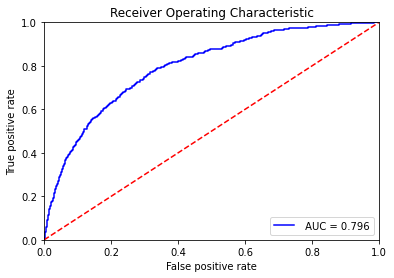

In [41]:
plt.title('Receiver Operating Characteristic') 
plt.plot( fpr, tpr, 'b', label =' AUC = %0.3f' % roc_auc) 
plt.legend( loc ='lower right') 
plt.plot([ 0, 1], [0, 1], 'r--') 
plt.xlim([ 0.0, 1.0]) 
plt.ylim([ 0.0, 1.0]) 
plt.ylabel('True positive rate') 
plt.xlabel('False positive rate') 
plt.show()

In [52]:
X_valid.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741 entries, 0 to 6740
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datum        6741 non-null   datetime64[ns]
 1   Lopp         6741 non-null   int64         
 2   VPN_SUM_ORD  6741 non-null   int64         
 3   VSVLPB       6741 non-null   float64       
 4   A_R          5933 non-null   float64       
 5   E_N          6741 non-null   float64       
 6   R_R          5043 non-null   float64       
 7   Ts_R         6741 non-null   int64         
 8   ToR          6260 non-null   float64       
 9   P_R          6096 non-null   float64       
 10  GRUPP        6741 non-null   int64         
 11  G_R          6344 non-null   float64       
 12  SVLP         6741 non-null   float64       
 13  VLPB         6741 non-null   float64       
 14  VPK_SUM      6741 non-null   float64       
 15  E_P_Num      6741 non-null   int64         
 16  TK_R  

In [56]:
label.reset_index()['y'].to_frame()

,y
0,1
1,0
2,0
3,0
4,0
...,...
6736,0
6737,0
6738,0
6739,0


__För varje häst plockar vi ut y, score, rankingen som ges av scoren samt datum, ger omgången__

In [50]:
scored_df = pd.DataFrame({'Score': list(predict2[:,1])})

In [64]:
outtake_df = pd.concat([X_valid.reset_index()[['Datum','Lopp']],label.reset_index()['y'].to_frame(), scored_df], axis = 1)

In [65]:
outtake_df.describe()

,Lopp,y,Score
count,6741.000000,6741.000000,6741.000000
mean,4.024329,0.085596,0.086030
std,1.985557,0.279787,0.108760
min,1.000000,0.000000,0.001716
25%,2.000000,0.000000,0.017055
50%,4.000000,0.000000,0.043687
75%,6.000000,0.000000,0.111952
max,7.000000,1.000000,0.591788


In [71]:
outtake_df = outtake_df.sort_values(['Datum','Lopp', 'Score'], ascending = [False, True, False])

In [72]:
outtake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6741 entries, 6658 to 82
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Datum   6741 non-null   datetime64[ns]
 1   Lopp    6741 non-null   int64         
 2   y       6741 non-null   int64         
 3   Score   6741 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 263.3 KB


In [73]:
outtake_df['ID'] = outtake_df.Datum.astype('str') + outtake_df.Lopp.astype('str')

__Vill beräkna positionen i varje omgång med avseende på score ==> Skapar lika många dataframes som det finns kombinationer av Datum och Lopp. Skapar sedan räknare från reset_index i varje frame__

In [84]:
id_list = list(set(outtake_df.ID.tolist()))

df_list = []

for idn in id_list:
    df = outtake_df[outtake_df.ID == idn].reset_index()
    df['Rank'] = range(len(df))
    df['Rank'] = df.Rank + 1
    
    df_list.append(df)

In [78]:
len(df_list)

581

In [86]:
df_list[100]

,index,Datum,Lopp,y,Score,ID,Rank
0,4918,2018-12-25,5,0,0.289473,2018-12-255,1
1,4916,2018-12-25,5,0,0.244629,2018-12-255,2
2,4908,2018-12-25,5,0,0.149949,2018-12-255,3
3,4917,2018-12-25,5,1,0.094589,2018-12-255,4
4,4915,2018-12-25,5,0,0.050884,2018-12-255,5
5,4911,2018-12-25,5,0,0.047377,2018-12-255,6
6,4914,2018-12-25,5,0,0.028406,2018-12-255,7
7,4909,2018-12-25,5,0,0.024152,2018-12-255,8
8,4913,2018-12-25,5,0,0.020308,2018-12-255,9
9,4912,2018-12-25,5,0,0.014051,2018-12-255,10


In [87]:
df_final = pd.concat(df_list, axis = 0)

In [94]:
df_final

,index,Datum,Lopp,y,Score,ID,Rank
0,1068,2017-02-04,1,0,0.411806,2017-02-041,1
1,1066,2017-02-04,1,1,0.185958,2017-02-041,2
2,1067,2017-02-04,1,0,0.167506,2017-02-041,3
3,1069,2017-02-04,1,0,0.087974,2017-02-041,4
4,1070,2017-02-04,1,0,0.060322,2017-02-041,5
...,...,...,...,...,...,...,...
7,481,2016-11-05,6,0,0.021053,2016-11-056,8
8,477,2016-11-05,6,0,0.016216,2016-11-056,9
9,476,2016-11-05,6,0,0.014193,2016-11-056,10
10,478,2016-11-05,6,0,0.007632,2016-11-056,11


__Gör en ny pipeline med en randomforrest__

In [95]:
df_final.sort_values(['Datum','Lopp', 'Score'], ascending = [True, True, False])[['Datum','Lopp','y','Score','Rank']].to_csv('ScoreRank.csv', index = False)

In [96]:
rf = RandomForestClassifier()

In [97]:
# Bygger vår pipeline
pipe3 = make_pipeline(ct2, rf)

In [98]:
# Validerar
cross_val_score(pipe3,X,y, cv = 5, scoring = 'roc_auc').mean()

0.8047518008938122

In [101]:
dt = DecisionTreeClassifier()

In [102]:
# Bygger vår pipeline
pipe4 = make_pipeline(ct2, dt)

In [103]:
# Validerar
cross_val_score(pipe4,X,y, cv = 5, scoring = 'roc_auc').mean()

0.5865898433769067

In [107]:
tree_model = pipe4.fit(X, y)

In [109]:
type(tree_model)

sklearn.pipeline.Pipeline

In [110]:
dir(tree_model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_transform',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_tr

In [105]:
from sklearn import tree

In [113]:
tree.plot_tree(pipe4.fit(X, y)) 

NotFittedError: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

__Nu ska vi jämföra modellen med hur det blir om vi plockar vnum1-3 i varje lopp och jämför med hur det vi blir när vi plockar de tre högst scorade i varje lopp. Antingen vill vi se ett mycket bättre utfall eller ett mycket sämre. Båda dessa utfallen kan användas för reducering. Det sämsta resultatet är om de visar exakt samma resultat__

__Först plockar vi ut de tre högst scorade i varje omgång med den valda modellen__

__Plockar ut sannolikheten för vinst och skapar en ny dataframe som håller y, score och omgång och lopp ==> lägger tillbaks mot validate__

In [46]:
df_predict = pd.DataFrame({'Score': predict2[:,1]})

In [47]:
df_predict.shape

(6604, 1)

In [48]:
validate.shape

(6604, 37)

In [49]:
df_analys = pd.concat([validate.reset_index(), df_predict], axis = 1)

In [50]:
# Vi utvärderar på 85 omgångar
df_analys.Datum.drop_duplicates().count()

81

In [51]:
# Således har vi 595 vinnare
df_analys.y.sum()

567

In [52]:
# Andelen vinnare om man plockar alla hästar i alla omgångar. Det är denna procentsats vi ska slå

df_analys.y.sum()/len(df_analys) * 100

8.585705632949727

In [53]:
# Här ser vi att modellen tilldelar våra vinnare en högre score ==> det är bra
df_analys.groupby('y').Score.mean()

y
0    0.074593
1    0.201627
Name: Score, dtype: float64

In [70]:
df_analys[df_analys.y == 1].Score.describe()

count    567.000000
mean       0.201627
std        0.163428
min        0.014378
25%        0.062290
50%        0.139603
75%        0.312661
max        0.646170
Name: Score, dtype: float64

In [54]:
# Fördelningen av scoren - vi ser att våra vinnare ligger klart fördelade i den övre kvartilen
df_analys.Score.describe()

count    6604.000000
mean        0.085500
std         0.101159
min         0.008313
25%         0.030657
50%         0.047032
75%         0.086028
max         0.652860
Name: Score, dtype: float64

In [55]:
# För varje omgång beräkna hur många hästar med Score >=  0.207979 som vinner. Vill se en jämn fördelning 

In [56]:
df_analys[df_analys.Score >=   0.207979].groupby('Datum').y.sum()

Datum
2016-05-28    1
2016-06-18    4
2016-07-07    3
2016-07-09    5
2016-07-24    3
             ..
2019-12-01    3
2019-12-07    2
2019-12-25    3
2019-12-26    4
2019-12-27    0
Name: y, Length: 78, dtype: int64

In [57]:
# Vi hittar bara 42% av vinnarna 
df_analys[df_analys.Score >= 0.207979].y.sum()/df_analys.y.sum()

0.4021164021164021

__Sorterar fallande på score och plockar 10%, hur stor är andelen vinnare då?__

In [58]:
df_analys_sorted = df_analys.sort_values('Score', ascending = False)

In [59]:
round(len(df_analys_sorted)* 0.1)

660

In [60]:
df_analys_sorted.iloc[:round(len(df_analys_sorted)* 0.1),:].y.sum()/len(df_analys_sorted.iloc[:round(len(df_analys_sorted)* 0.1),:]) * 100

33.63636363636363

In [61]:
# Gain - hur mycket bättre modellen är en slumpen i översta decilen

(df_analys_sorted.iloc[:round(len(df_analys_sorted)* 0.1),:].y.sum()/len(df_analys_sorted.iloc[:round(len(df_analys_sorted)* 0.1),:]) * 100) / (df_analys.y.sum()/len(df_analys) * 100)

3.917716851050184

__Nu vill vi för varje omgång idenfiera de lopp med högst sannolikhet att ha vinnarna bland de tre högs scorade hästarna. Vi sammanfattar varje omgång och summerar vinnarna__

In [62]:
df_analys.Datum.drop_duplicates().count()

81

In [63]:
datum_list = list(set(df_analys.Datum.tolist()))

omg_list = []

for date in datum_list:
    df = df_analys[df_analys.Datum == date]
    i = 0
    for lopp in [1,2,3,4,5,6,7]:
        ldf = df[df.Lopp == lopp]
        ldf = ldf.sort_values('Score', ascending = False)
        vin = ldf.iloc[:3].y.sum()
        i = i + vin
    omg_list.append(i)
    

In [64]:
# Listan visar hur många hästar i varje omgång vi hade haft som vinnare om vi plockat de tre högst scorade i varje lopp
omg_list

[5,
 7,
 7,
 4,
 5,
 3,
 4,
 2,
 5,
 5,
 4,
 5,
 4,
 4,
 7,
 5,
 6,
 4,
 3,
 5,
 5,
 5,
 4,
 6,
 2,
 7,
 4,
 5,
 5,
 3,
 5,
 6,
 4,
 5,
 6,
 5,
 4,
 4,
 4,
 3,
 2,
 6,
 5,
 7,
 4,
 7,
 4,
 5,
 4,
 6,
 5,
 6,
 5,
 3,
 6,
 5,
 6,
 7,
 4,
 3,
 3,
 4,
 5,
 5,
 6,
 5,
 2,
 5,
 5,
 5,
 4,
 5,
 4,
 4,
 5,
 5,
 4,
 4,
 5,
 3,
 3]

In [65]:
# Beräknar medelvärdet för de 85 omgångarna med model
pd.DataFrame(omg_list).mean()

0    4.654321
dtype: float64

In [66]:
### Nu plockar vi VNUM1-3 och jämför

In [67]:
datum_list = list(set(df_analys.Datum.tolist()))

vnum_list = []

for date in datum_list:
    df = df_analys[df_analys.Datum == date]
    i = 0
    for lopp in [1,2,3,4,5,6,7]:
        ldf = df[(df.Lopp == lopp) & (df.VNUM.isin([1,2,3]))]
        vin = ldf.iloc[:3].y.sum()
        i = i + vin
    vnum_list.append(i)

In [68]:
# Beräknar medelvärdet för de 85 omgångarna VNUM1-3
pd.DataFrame(vnum_list).mean()

0    4.975309
dtype: float64

### Slutsats: Modellen är marginellt sämre (medelvärde 4.6 vinnare på 85 omgångar)  jämfört med VNUM1-3 (ger 4.9 vinnare på 85 omgångar). 